# Zonal_mpsi using UXarray

Work on [NCL's zonal_mpsi](https://www.ncl.ucar.edu/Document/Functions/Built-in/zonal_mpsi.shtml) with a UXarray dataset.

Zonal mean meridional stream function

*v*: A multi-dimensional array of meridional wind values

*lat*: A one-dimensional array of latitudes.

*p*: A one-dimensional array of pressure level values ordered top-to-bottom.

*ps*: A multi-dimensional numeric array of surface pressures.

$MPSI(lev,lat) = \frac{2 {\pi} a cos(lat)}{g} \int_{p}^{PS} \bar{v} \,dp$

In [1]:
import uxarray as ux
import xarray as xr
import numpy as np
import geocat.datafiles as gdf

Updating file 'registry.txt' from 'https://github.com/NCAR/GeoCAT-datafiles/raw/main/registry.txt' to '/Users/jkent/Library/Caches/geocat'.


In [2]:
# Constants
a = 6.371e6  # Earth radius (m)
g = 9.80665  # gravity (m/s^2)

Need a datset with: wind speed values (lat, long, time, maybe lev), vertical pressure levels, and spatial surface pressure

## Read in Data

In [5]:
data_path = 'netcdf_files/e2p3b09.F2000climo.ne30pg3.ctl002.cam.h0.0005-01.zonal_mpsi_subset.nc'
grid_path = 'netcdf_files/ne30pg3_scrip_170604.nc'

uxds = ux.open_dataset(gdf.get(grid_path), gdf.get(data_path))
uxds

<xarray.UxDataset> Size: 7MB
Dimensions:  (n_face: 48600, time: 1, lev: 32, ilev: 33)
Coordinates:
  * lev      (lev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev     (ilev) float64 264B 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time     (time) object 8B 0005-02-01 00:00:00
Dimensions without coordinates: n_face
Data variables:
    lat      (n_face) float64 389kB ...
    PS       (time, n_face) float32 194kB ...
    V        (time, lev, n_face) float32 6MB ...
    hyam     (lev) float64 256B ...
    hybm     (lev) float64 256B ...
    hyai     (ilev) float64 264B ...
    hybi     (ilev) float64 264B ...

The data hasn't been interpolated to pressure levels (still on hybrid sigma levels)

In [6]:
# Grabbing correct data variables, confirming long names
print(uxds.lat.attrs['long_name'],', ',
      uxds.PS.attrs['long_name'],', ',
      uxds.V.attrs['long_name'],', ',
      uxds.hyam.attrs['long_name'],', ', 
      uxds.hybm.attrs['long_name'],', ',
      uxds.hyai.attrs['long_name'],', ', 
      uxds.hybi.attrs['long_name'])

latitude ,  Surface pressure ,  Meridional wind ,  hybrid A coefficient at layer midpoints ,  hybrid B coefficient at layer midpoints ,  hybrid A coefficient at layer interfaces ,  hybrid B coefficient at layer interfaces


## Converting from sigma hybrid coordinates to Pressure levels

$p(k) = hya(k) * p_0 + hyb(k) * p_{surface}$

Source: [NCL `sigma2hybrid` documentation](https://www.ncl.ucar.edu/Document/Functions/Built-in/sigma2hybrid.shtml)

In [7]:
# Convert sigma hybrid coordinates to pressure levels

p0 = 100000
pm = uxds.hyam * p0 + uxds.hybm * uxds.PS
pm.attrs['long_name'] = 'pressure midpoints'
pm.attrs['units'] = 'Pa'
uxds = uxds.assign({"pm":pm})

pi = uxds.hyai * p0 + uxds.hybi * uxds.PS
pi.attrs['long_name'] = 'pressure interfaces'
pi.attrs['units'] = 'Pa'
uxds = uxds.assign({"pi":pi})

## Preparing and Performing the Integral

In [8]:
scaling_factor = 2 * np.pi * a * np.cos(uxds.lat) / g

# zonal mean wind
v_zonal = uxds.V.zonal_mean()

# zonal mean on integration bounds
PS_zonal = uxds.PS.zonal_mean()
pm_zonal = uxds.pm.zonal_mean()
pi_zonal = uxds.pi.zonal_mean()

In [9]:
# Calculate dp from pressure interfaces
dp = pi_zonal.isel(ilev=slice(1, None)) - pi_zonal.isel(ilev=slice(None, -1))

In [10]:

# Mask out levels above the surface (where p_i > PS_zonal)
mask = pi_zonal.isel(ilev=slice(1, None)) <= PS_zonal
dp = dp.where(mask)
v_masked = v_zonal.where(mask)

In [11]:
# Integrate v*dp from each level to the surface (cumulative sum from top)
mpsi = (v_masked * dp).cumsum(dim='ilev')

# Apply scaling factor (broadcast to shape)
mpsi = scaling_factor * mpsi
mpsi

<xarray.DataArray (n_face: 48600, time: 1, lev: 32, latitudes: 19, ilev: 32)> Size: 8GB
array([[[[[-1.19129245e+06, -3.39081499e+06, -6.99387451e+06, ...,
           -2.81094074e+08, -2.85657701e+08, -2.89989414e+08],
          [-3.06465612e+06, -8.72303185e+06, -1.79920728e+07, ...,
           -8.37956785e+08, -8.52265364e+08, -8.65183106e+08],
          [-6.35414144e+06, -1.80860024e+07, -3.73040793e+07, ...,
           -1.97829735e+09, -2.01335275e+09, -2.01335275e+09],
          ...,
          [ 3.35602827e+09,  9.55237398e+09,  1.97026688e+10, ...,
            1.13608124e+12,  1.15663650e+12,  1.15663650e+12],
          [ 3.42703338e+09,  9.75447818e+09,  2.01195277e+10, ...,
            1.16241916e+12,  1.18346080e+12,  1.20138828e+12],
          [ 3.22829077e+08,  9.18879055e+08,  1.89527438e+09, ...,
            1.12793246e+11,  1.14849029e+11,  1.14849029e+11]],

         [[-8.61216271e+05, -2.45130829e+06, -5.05605366e+06, ...,
           -2.03210212e+08, -2.06509376e+08, -2.09640884e+08],
          [ 1.15588870e+06,  3.29004414e+06,  6.78602516e+06, ...,
            3.16050068e+08,  3.21446799e+08,  3.26318952e+08],
          [ 6.77221073e+05,  1.92759668e+06,  3.97584927e+06, ...,
            2.10845898e+08,  2.14582084e+08,  2.14582084e+08],
...
          [-3.02373256e+08, -8.60654977e+08, -1.77518175e+09, ...,
           -1.02359264e+11, -1.04211263e+11, -1.04211263e+11],
          [-8.13304655e+07, -2.31493588e+08, -4.77477274e+08, ...,
           -2.75865686e+10, -2.80859295e+10, -2.85113851e+10],
          [-2.35013847e+07, -6.68927667e+07, -1.37972616e+08, ...,
           -8.21114841e+09, -8.36080575e+09, -8.36080575e+09]],

         [[-1.63811655e+08, -4.66262519e+08, -9.61710254e+08, ...,
           -3.86525455e+10, -3.92800785e+10, -3.98757216e+10],
          [-7.39509603e+07, -2.10489058e+08, -4.34153459e+08, ...,
           -2.02201182e+10, -2.05653879e+10, -2.08770965e+10],
          [-5.36690930e+08, -1.52760110e+09, -3.15082080e+09, ...,
           -1.67093266e+11, -1.70054156e+11, -1.70054156e+11],
          ...,
          [-3.52026447e+08, -1.00198449e+09, -2.06668715e+09, ...,
           -1.19167840e+11, -1.21323960e+11, -1.21323960e+11],
          [-1.69622360e+08, -4.82801720e+08, -9.95823908e+08, ...,
           -5.75343918e+10, -5.85758559e+10, -5.94631838e+10],
          [-9.87529281e+06, -2.81083718e+07, -5.79761577e+07, ...,
           -3.45032839e+09, -3.51321447e+09, -3.51321447e+09]]]]])
Coordinates:
  * latitudes  (latitudes) int64 152B -90 -80 -70 -60 -50 -40 ... 50 60 70 80 90
Dimensions without coordinates: n_face, time, lev, ilev

# Plotting

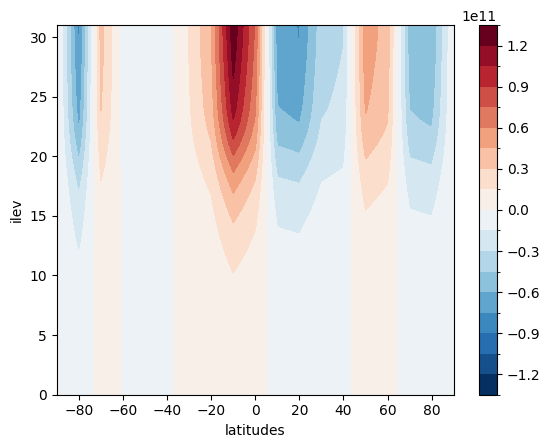

In [12]:
# Select a single n_face (e.g., the first one) for plotting
mpsi.isel(n_face=0, time=0, lev=20).plot.contourf(x='latitudes', y='ilev', levels=20, add_colorbar=True)

I'm getting confused about how my mpsi has both ilev (from interface pressures) and lev (from midpoint pressures). These are linked, in that I probably want to drop one of them.

Also having latitude as a variable separate from the grid information. I'll want to touch base on this.